In [25]:
import torch
from torch import nn
import gpytorch
# from torchsummary import summary

import matplotlib.pyplot as plt
import gc

from warp_units import *
from func_polygon import *
from func_data_generation import *

from utils import *

dtype=torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm
torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module('axial_dim0', AxialWarpUnit(dim=0, res=50, grad=20, lims=[0, 1.0]))
        self.add_module('axial_dim1', AxialWarpUnit(dim=1, res=50, grad=20, lims=[-1.0, 0]))
        self.add_module('rbf_seq1', rbfunit_sequential(res=1, ylim=[-1.0, 0.0]))
        self.add_module('rbf_seq2', rbfunit_sequential(res=2, ylim=[-1, 0]))
        self.add_module('mobius', MobiusWarpUnit())
        
        
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, warp_model):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
#             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
#                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
#                 num_dims=2, grid_size=100
#             )
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
            self.space_transform = warp_model

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.space_transform(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [27]:
train_X = torch.load(DATA_PATH+ '/train_X').to(device)
train_y = torch.load(DATA_PATH+ '/train_y').to(device)

In [28]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_X, train_y, likelihood).to(device)


In [11]:
chessboard_from_model(warp_model.rbf_seq1)

NameError: name 'warp_model' is not defined

In [13]:
for name, param in model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")

Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True) 

Layer:mean_module.constant | Size:torch.Size([1]) | Values : Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 0.0 

Layer:covar_module.base_kernel.raw_lengthscale | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True) 



In [14]:
train_X.shape

torch.Size([1000, 2])

In [32]:
model.train()
likelihood.train()
training_iterations = 1000
# Use the adam optimizer
optimizer = torch.optim.Adam([
#     {'params': gp_model.space_transform.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
#     {'params': gp_model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_X)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 18.2 s, sys: 176 ms, total: 18.3 s
Wall time: 18.1 s


In [19]:

for name, param in model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True) 

Layer:mean_module.constant | Size:torch.Size([1]) | Values : Parameter containing:
tensor([9.4117], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 10.545191728183804 

Layer:covar_module.base_kernel.raw_lengthscale | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[5.2983e-34]], device='cuda:0', requires_grad=True) 



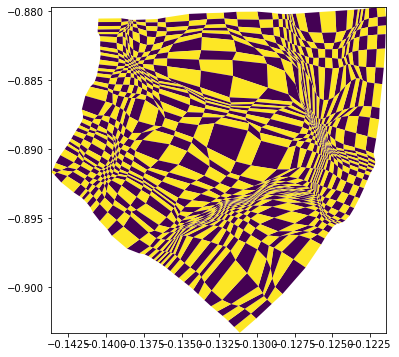

In [68]:
chessboard_from_model(warp_model)

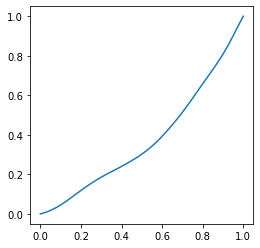

In [69]:
oned_map(warp_model.axial_dim0, dim=0)

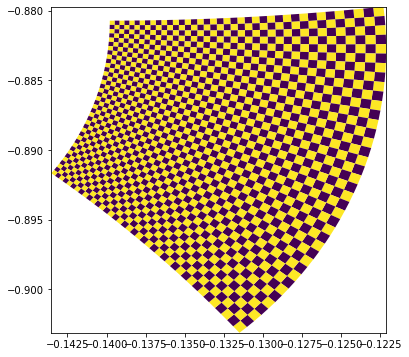

In [70]:
chessboard_from_model(warp_model.mobius)

In [71]:
for name, param in gp_model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")


Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 3.8451674509228817 

Layer:covar_module.base_kernel.raw_lengthscale | Size:torch.Size([1, 2]) | Values : Parameter containing:
tensor([[-1.2949, -0.8087]], device='cuda:0', requires_grad=True) 

Layer:space_transform.axial_dim0.weight_true | Size:torch.Size([1, 50]) | Values : Parameter containing:
tensor([[-1.3086, -1.4292, -0.1505,  0.1009,  0.0379,  0.8681, -0.5284,  1.0904,
          1.3635, -0.8802, -0.7721, -0.4259,  1.3874,  0.2836, -0.6508, -0.5819,
         -0.2189,  0.0362, -0.2724, -0.1316, -0.0490, -0.5952,  0.4791,  0.3734,
          0.1782,  0.5037, -0.6201, -1.7035,  0.0219, -0.6836,  2.3110, -0.3004,
          0.7624, -1.7850,  0.7278, -0.1928, -0.0807,  2.4983,  0.7542, -1.2468,
         -1.5269,  2.2173, -0.4645, -0.2889,  0.0537, -0.4558,  0.6646, -0.6307,

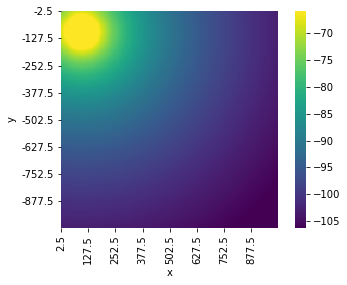

In [33]:
likelihood.eval()
model.eval()
coords, rss = get_field_data(200, 30, torch.tensor([[100, -100]]))  # 200*200显存上限
coords = coords.to(device)
observed_pred = model(coords/1000)
data = observed_pred.mean.detach()

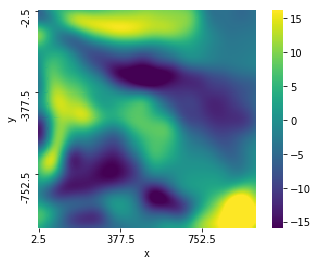

In [34]:
plot_heatmap(coords, data)

In [22]:
observed_pred

MultivariateNormal(loc: torch.Size([40000]))

In [21]:

 temp = 1.0 + torch.exp(torch.tensor(1.5))/2.0

In [22]:
temp

tensor(3.2408)

In [21]:
point = torch.tensor([[2.5, -2.5]]).to(device)
warp_model(point)

tensor([[ 2.6314, -1.8408]], device='cuda:0', grad_fn=<StackBackward>)